# NEUS 642 - Week 3 Homework

Your goal for the day? Perform a real statistical test on real data. In this case, you'll perform a T-test the assess the significance of changes in the auditory brainstem response (ABR) following noise exposure. Along the way, we'll deal with the very normal problem of missing/incomplete data.

## Reload the ABR dataset

To continue working with pandas, let's start by loading the exposure and threshold files from lecture and joining the tables into the `data` DataFrame.

In [27]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 7

# other imports useful for this homework
import matplotlib.pyplot as plt
from scipy import stats

In [28]:
exposure_data = pd.read_csv('exposure_data.csv', index_col=0, parse_dates=['exposure_date'])
threshold_data = pd.read_csv('abr_thresholds.csv', parse_dates=['abr_date'])
data = threshold_data.join(exposure_data, on=['animal'])

# pivot to one column per timepoint
data['days_re_exposure'] = (data['abr_date'] - data['exposure_date']).astype(str)
data_timepoints = data.pivot(columns='days_re_exposure', index=['animal', 'ear', 'exposure_level'], values='threshold').reset_index()

In [29]:
data_timepoints

days_re_exposure,animal,ear,exposure_level,-3 days,1 days,14 days
0,Subject 1,left,110,40.0,NaN,35.0
1,Subject 1,right,110,30.0,NaN,40.0
2,Subject 10,left,114,35.0,60.0,30.0
...,...,...,...,...,...,...
73,Subject 8,right,114,30.0,NaN,45.0
74,Subject 9,left,114,35.0,NaN,35.0
75,Subject 9,right,114,35.0,NaN,45.0


As you see here, and might remember from lecture, there are *NaNs* (special numpy value meaning "not a number") in cells where data was not collected. You'll have to deal with that in your homework.

## Question 1 - Paired T-test

We want to determine if the change in hearing threshold following noise exposure is significant. There are many ways to do this. But let's start with an old standard, the paired T-test. A paired T-test considers changes within-animal and can sometimes before more powerful than its cousin, the independent (or unpaired) T-test. Conveniently, the scientific python packages, scipy, has a T-test built in.

In [30]:
from scipy import stats
stats.ttest_rel

<function scipy.stats._stats_py.ttest_rel(a, b, axis=0, nan_policy='propagate', alternative='two-sided', *, keepdims=False)>

Write a function `my_ttest` that takes a dataframe and two column names as inputs and returns the results `T, p` of a T-test in a tuple. 

Remember that you have to exclude rows containing NaN values for this to work! There are many ways to deal with this issue. Some solutions are built into pandas. And/or notice the `nan_policy` parameter in `ttest_rel`

In [31]:
def my_ttest(df, col1, col2):
    """ Perform a paired T-test between two columns of a dataframe
    Inputs:
    df : dataframe
    col1, col2 : string names of columns to compare
    Returns:
    T, p : tuple of T score and p value resulting from paired t-test
    """
    # Your answer here
    a=df[col1]
    b=df[col2]
    res = stats.ttest_rel(a,b, nan_policy='omit')
    T=res.statistic
    p=res.pvalue
    return T, p

Test it out:

In [32]:
T, p = my_ttest(data_timepoints, '-3 days', '1 days')
print(f"T={T:.3f} p={p:.3e}")

T=-14.703 p=1.367e-18


In [33]:
T, p = my_ttest(data_timepoints, '-3 days', '14 days')
print(f"T={T:.3f} p={p:.3e}")

T=-3.906 p=2.588e-04


## Question 2 - Avoiding bias from multiple measurements.

When you look at data from each animal in the cell above, notice that there are two measurements on each day, one for the left ear and one for the right ear. You might also notice that they tend to be similar on the same day. To perform a more conservative T-test, let's average thresholds across ears for each animal before evaluating the signficance of the threshold change. 

Using the `groupby` and `mean` methods, generate a new DataFrame `data_ear_averaged`, which averages data across ears. Then send your new dataframe through `my_ttest` that you wrote for question 1.

In [34]:
#Your answer here
data_ear_averaged = data_timepoints.groupby('animal').mean(numeric_only=True)
data_ear_averaged

days_re_exposure,exposure_level,-3 days,1 days,14 days
animal,,,,
Subject 1,110.0,35.0,NaN,37.5
Subject 10,114.0,35.0,60.0,32.5
Subject 11,114.0,50.0,75.0,47.5
...,...,...,...,...
Subject 7,114.0,60.0,NaN,50.0
Subject 8,114.0,32.5,NaN,45.0
Subject 9,114.0,35.0,NaN,40.0


Test it out:

In [35]:
T, p = my_ttest(data_ear_averaged, '-3 days', '1 days')
print(f"T={T:.3f} p={p:.3e}")

T=-13.324 p=7.382e-13


In [36]:
T, p = my_ttest(data_ear_averaged, '-3 days', '14 days')
print(f"T={T:.3f} p={p:.3e}")

T=-3.388 p=1.932e-03


## Question 3 - Scatter plot

Use your documnation searching skills to figure out how to generate a scatter plot comparing thresholds for each animal between two timepoints, eg, `-3 days` and `1 days` or  `-3 days` and `14 days`.  You can plot data for each measurement or the average across ears. Or both!

Let's also make the plot tidy: 
* Color the dots differently for the different noise exposure levels.
* Make sure the axes are labeled.
* Include a dashed, diagonal line running from (20,20) to (80,80), so it's easy to see which way the thresholds have shifted.
* In the title, report the results of your paired T-test.
* Optional: If you want to get fancy, make the color of the dots depend on noise exposure level.

You will likely need to use a combinations of dataframe methods and calls to matplotlib functions. 

In [37]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'T=-3.388 p=1.932e-03')

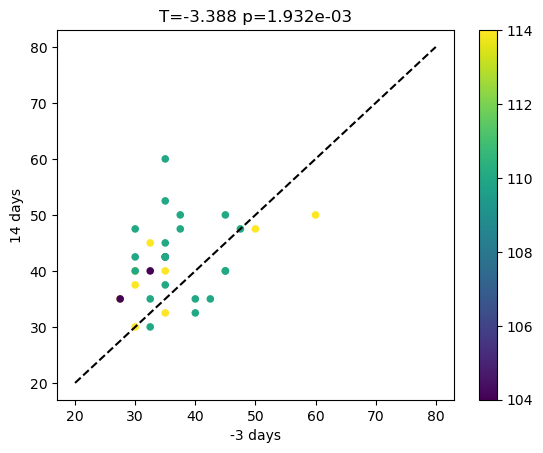

In [38]:
# Your answer here
col1 = '-3 days'
col2 = '14 days'
T, p = column_ttest_rel(data_ear_averaged, col1, col2)
data_ear_averaged.plot.scatter(col1,col2,c=data_ear_averaged['exposure_level'],cmap='viridis')
plt.plot([20,80],[20,80], 'k--')
plt.title(f"T={T:.3f} p={p:.3e}")

## Bonus - Significant effect of noise exposure level?

We've ignored the `exposure_level` column in the homework so far. This number indicates the intensity of the noise exposure, and in class we saw that the louder noise exposure may produce more severe hearing loss on day 1 after exposure. Can you perform T-tests to compare the mean threshold change between the 104, 110 and 114 dB exposure groups?

Logic: 
1. Define a new column as the threshold difference between -3 days and 1 days post-exposure
2. For each exposure level (104, 110 or 114 dB), select the subset of rows for that group.
3. Perform a t-test comparing the mean change in threshold between these exposure groups. Report the T score and p value.
4. Do you think this is a definitive result? Why/why not? Should you average across ears before testing or not?

Important: This will require an *independent* T-test, since the same animal cannot be in different exposure groups. This is implemented in a different scipy function.

In [39]:
from scipy import stats
stats.ttest_ind

<function scipy.stats._stats_py.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0, *, keepdims=False)>

In [ ]:
# Your answer here

df = data_ear_averaged
df['prepost']=df['1 days']-df['-3 days']
df=df.dropna()
data104=df.loc[df['exposure_level']==104].copy()
data110=df.loc[df['exposure_level']==110].copy()
data114=df.loc[df['exposure_level']==114].copy()

res = stats.ttest_ind(data104['prepost'],data110['prepost'], alternative='less')
print(f"104 v 110: T={res.statistic}, p={res.pvalue}")
res = stats.ttest_ind(data104['prepost'],data114['prepost'], alternative='less')
print(f"104 v 114: T={res.statistic}, p={res.pvalue}")
res = stats.ttest_ind(data110['prepost'],data114['prepost'], alternative='less')
print(f"110 v 114: T={res.statistic}, p={res.pvalue}")


Ns are small, and test is likely underpowered:

In [60]:
df.groupby('exposure_level').count()[['prepost']]

days_re_exposure,prepost
exposure_level,
104.0,3
110.0,16
114.0,6


But given the nature of the experiment, we could perform a 1-sided t-test. The quieter noise exposure should have a weaker effect:

In [65]:
res = stats.ttest_ind(data104['prepost'],data110['prepost'], alternative='less')
print(f"1-sided 104 v 110: T={res.statistic}, p={res.pvalue}")
res = stats.ttest_ind(data104['prepost'],data114['prepost'], alternative='less')
print(f"1-sided 104 v 114: T={res.statistic}, p={res.pvalue}")
res = stats.ttest_ind(data110['prepost'],data114['prepost'], alternative='less')
print(f"1-sided 110 v 114: T={res.statistic}, p={res.pvalue}")


1-sided 104 v 110: T=-0.5532532035387795, p=0.29364646673871475
1-sided 104 v 114: T=-1.9321835661585918, p=0.04730884369400016
1-sided 110 v 114: T=-1.4463633350216774, p=0.08178307926155104
